# Autoencoder Recommendation System

**Autoencoder-based Collaborative Filtering System**
Implements AutoRec model using matrix factorization through neural networks to learn user preference patterns for book recommendations.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from time import time
from collections import Counter
import ast

import torch
import torch.nn as nn 
import torch.nn.functional as F 
import torchvision 
import torch.utils.data as data
import torch.distributions as dist
import tqdm

## Data Preparation

**Scalability Optimization**
Limiting to top 2000 books by rating count reduces computational complexity while maintaining recommendation quality.

In [2]:
df_books = pd.read_csv('books_autorec.csv')
df_books.sort_values(by='ratings_count', ascending=False, inplace=True)
Books_number = 2000
df_books = df_books.iloc[:Books_number]
df_books['goodreads_book_id'] = df_books['goodreads_book_id'].astype(int)
book_ids = df_books['goodreads_book_id']

Create filtered user dictionary containing only users who rated books in the selected 2000-book subset.

In [3]:
df = pd.read_csv("books_autorec.csv")
df_ratings = pd.read_csv("ratings_autorec.csv")

modified_df_ratings = df_ratings.merge(
    df[['goodreads_book_id']],
    left_on='book_id',
    right_on='goodreads_book_id',
    how='left'
)

# create dictionary with user and ratings
sparse_users = {}
for user_id, group in modified_df_ratings.groupby('user_id'):
    modified_books_ratings = group[['book_id', 'rating']].values.tolist()
    sparse_users[user_id] = modified_books_ratings

filter_users = {
    user: [triplet for triplet in triplets if triplet[0] in book_ids]
    for user, triplets in sparse_users.items()
}
filter_users = {user: triplets for user, triplets in filter_users.items() if triplets}
#user taken
taken_users = 50000
filter_users = sorted(filter_users.items(), key=lambda x: len(x[1]), reverse=True)[:taken_users]
filter_users = dict(filter_users)

Establish bidirectional mappings between array positions and book/user IDs for matrix operations.

In [4]:
mapping_pos_to_books = dict(zip(range(Books_number), book_ids))
mapping_books_to_pos = dict(zip(book_ids,range(Books_number)))
mapping_pos_to_users = dict(zip(range(taken_users), filter_users.keys()))
mapping_users_to_pos = dict(zip(filter_users.keys(),range(taken_users)))

Convert explicit ratings to binary implicit feedback (1 if rating ≥4, 0 otherwise) and create user-item matrix.

In [5]:
n_books = len(mapping_books_to_pos)
user_vectors = []
for user_id, book_rating in filter_users.items():
    vector = np.zeros(n_books)  # initialize vector with zeros

    for book_id, rating in book_rating:
        if book_id in mapping_books_to_pos:  # if book_id is in the mapping
            index = mapping_books_to_pos[book_id]
            vector[index] = rating  # insert rating in the correct position

    user_vectors.append(vector)

print("Number of Users", len(user_vectors))
print("Number of Books", len(user_vectors[0]))
for i in range(len(user_vectors)):
    user_vectors[i] = [0 if elem < 4 else 1 for elem in user_vectors[i]]
print("Example of a user: ", user_vectors[0][:20])
df_input_data = pd.DataFrame(user_vectors)

Number of Users 48939
Number of Books 2000
Example of a user:  [0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1]


Calculate inverse linear, logarithmic, and square root weights for items to reduce popularity bias in the loss function.
We decided to use the inverse logarithmic strategy as it provides a good balance between popular and less popular items, allowing the model to learn from both without being overly influenced by the most popular items.

In [6]:
def compute_item_weights(df_input_data, weight_strategy='inverse_log'):
    item_review_counts = (df_input_data != 0).sum(axis=0)

    if weight_strategy == 'inverse':
        item_weights = 1.0 / (item_review_counts + 1)
    elif weight_strategy == 'inverse_log':
        item_weights = 1.0 / np.log(item_review_counts + 2)
    elif weight_strategy == 'inverse_sqrt':
        item_weights = 1.0 / np.sqrt(item_review_counts + 1)
    else:
        raise ValueError("Invalid weight strategy")

    item_weights = item_weights / item_weights.mean()

    print(f"Item weights stats:")
    print(f"  Min weight: {item_weights.min():.4f}")
    print(f"  Max weight: {item_weights.max():.4f}")
    print(f"  Mean weight: {item_weights.mean():.4f}")
    print(f"  Std weight: {item_weights.std():.4f}")

    return torch.tensor(item_weights.values, dtype=torch.float32)

item_weights = compute_item_weights(df_input_data, weight_strategy='inverse_log')

Item weights stats:
  Min weight: 0.0731
  Max weight: 1.0356
  Mean weight: 1.0000
  Std weight: 0.1793


## Clustering
The division of books in clusters is used only in the new user generation

Convert string representations of tag lists back to actual Python lists for processing:

In [7]:
def string_to_list(stringa):
    lista = [elemento.strip() for elemento in stringa.split(",")]
    for i, element in enumerate(lista):
        lista[i] = element.strip('[').strip(']').strip('\'')
    return lista

df_books['tags_list'] = df_books['tags_list'].apply(string_to_list)

Create TF-IDF feature vectors from book tags for content-based similarity computation.

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer()
X = tfidf.fit_transform(df_books['tags_string'])

Group books into 8 semantic clusters based on TF-IDF tag similarities.

In [9]:
from sklearn.cluster import KMeans

k = 10
kmeans_model = KMeans(n_clusters=k, random_state=33, max_iter=1000, n_init=10)
df_books['cluster'] = kmeans_model.fit_predict(X)

Display the distribution of books across clusters to verify balanced clustering.

In [10]:
cluster_counts = df_books['cluster'].value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"Cluster {cluster_id}: {count} elements")

Cluster 0: 280 elements
Cluster 1: 245 elements
Cluster 2: 136 elements
Cluster 3: 265 elements
Cluster 4: 215 elements
Cluster 5: 101 elements
Cluster 6: 46 elements
Cluster 7: 188 elements
Cluster 8: 276 elements
Cluster 9: 248 elements


Define and execute a function to analyze and validate cluster quality by examining most frequent tags per cluster, showing top tags for each cluster

In [11]:
def print_top_tags_per_cluster(df, top_n=20):

    for cluster_id in sorted(df['cluster'].unique()):
        tags = df[df['cluster'] == cluster_id]['tags_list'].explode()
        tag_counts = Counter(tags)
        most_common = tag_counts.most_common(top_n)
        print(f"\nCluster {cluster_id}:")
        for tag, count in most_common:
            print(f"  {tag}")

In [12]:
print_top_tags_per_cluster(df_books, top_n=10)


Cluster 0:
  fiction
  favorites
  books-i-own
  owned
  adult
  owned-books
  library
  book-club
  novels
  currently-reading

Cluster 1:
  fantasy
  favorites
  owned
  fiction
  books-i-own
  paranormal
  currently-reading
  i-own
  library
  series

Cluster 2:
  currently-reading
  owned
  books-i-own
  my-library
  library
  owned-books
  default
  favorites
  to-buy
  non-fiction

Cluster 3:
  favorites
  fiction
  literature
  books-i-own
  owned
  to-buy
  my-books
  default
  adult
  library

Cluster 4:
  children-s
  children-s-lit
  favorites
  kids-books
  fiction
  childrens
  childrens-books
  children
  books-i-own
  children-s-books

Cluster 5:
  non-fiction
  nonfiction
  owned
  biography-memoir
  owned-books
  biography
  biographies
  to-buy
  library
  favorites

Cluster 6:
  graphic-novels
  favorites
  graphic-novel
  fiction
  owned
  currently-reading
  books-i-own
  favourites
  owned-books
  graphic

Cluster 7:
  fiction
  mystery
  favorites
  owned
  book

## Training

Define symmetric autoencoder architecture with 2D bottleneck (2000→500→250→125→50→2→...→2000).

In [13]:
class Spatial_F_AE(nn.Module):
    def __init__(self,k):
        super(Spatial_F_AE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(k,500),
            nn.ReLU(),
            nn.Linear(500,250),
            nn.ReLU(),
            nn.Linear(250,125),
            nn.ReLU(),
            nn.Linear(125,50),
            nn.ReLU(),
            nn.Linear(50,2)
        )
        self.decoder = nn.Sequential(
            nn.Linear(2,50),
            nn.ReLU(),
            nn.Linear(50,125),
            nn.ReLU(),
            nn.Linear(125,250),
            nn.ReLU(),
            nn.Linear(250,500),
            nn.ReLU(),
            nn.Linear(500,k),
            nn.Sigmoid(),
        )
    def forward(self,x):
        z = self.encoder(x)
        final = self.decoder(z)
        return final

Implement custom training loop with weighted loss function.

In [14]:
def train(model, dataloader, criterion, optimizer, num_epochs, item_weights=None, scheduler=None, best_loss=float('inf')):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    losses = []
    model.to(device)

    # Move weights to device if provided
    if item_weights is not None:
        item_weights = item_weights.to(device)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, batch in enumerate(dataloader):
            inputs = batch[0]
            inputs = inputs.to(device)
            recon = model(inputs)

            if item_weights is not None:
                # evaluate weighted loss
                squared_errors = (recon - inputs) ** 2
                weighted_errors = squared_errors * item_weights.unsqueeze(0)  # Broadcast sui batch
                loss = weighted_errors.mean()
            else:
                # standard loss
                loss = criterion(recon, inputs)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if scheduler is not None:
                scheduler.step(loss.item())
            running_loss += loss.item()

        losses.append(running_loss / (i + 1))
        if running_loss < best_loss:
            best_loss = running_loss
            torch.save(model.state_dict(), 'best_model.pth')
        print(f"Epoch {epoch+1}: Loss = {running_loss / (i + 1):.10f}")
    return losses

Define visualization function for training loss progression.

In [15]:
def loss_graph(tr_loss,n_epochs):
    plt.plot(range(n_epochs),tr_loss,label='tr_loss', c='black')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    plt.show()

Convert user-item matrix to PyTorch tensors and instantiate autoencoder model.

In [16]:
tensor_data = torch.tensor(df_input_data.values, dtype=torch.float32)
dataset = torch.utils.data.TensorDataset(tensor_data)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
model = Spatial_F_AE(Books_number)

It the model is already trained and you see the best_model.pth file in the repository you can avoid retraining and run the followinc cell to sideload the weights of the model

In [17]:
# model.load_state_dict(torch.load('best_model.pth'))

Actual train of the model:

Epoch 1: Loss = 0.0018723988
Epoch 2: Loss = 0.0002041616
Epoch 3: Loss = 0.0002041162
Epoch 4: Loss = 0.0002040522
Epoch 5: Loss = 0.0002040235


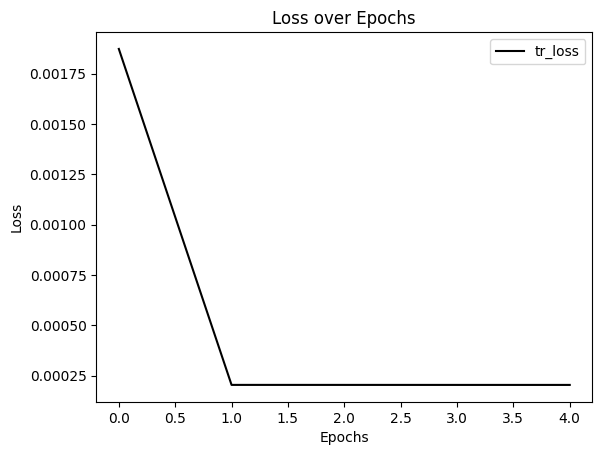

In [18]:
criterion = nn.MSELoss()
N_Epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr = 0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2)

losses = train(model, dataloader, criterion, optimizer, N_Epochs, item_weights, scheduler)
loss_graph(losses, N_Epochs)

## Find Recommendations

Generate top-N recommendations by masking known items and selecting highest reconstruction scores.

In [19]:
def recommendations(user, model, n=25):
    model.eval()
    recon = model(user)

    recon_masked = recon.clone()
    recon_masked[user != 0] = float('-inf')  # already read books are not recommended

    _, new_books = torch.topk(recon_masked, n)
    new_books = new_books.tolist()

    new_books_map = [mapping_pos_to_books[pos] for pos in new_books]
    new_titles = [df_books[df_books['goodreads_book_id'] == id].values.tolist()[0][5] for id in new_books_map]

    return new_titles, new_books_map

Display a specific user's rating history for manual inspection and validation.

In [32]:
def print_users_ratings(us):
    utente = df_ratings[df_ratings['user_id'] == us]
    utente = utente[['book_id', 'rating']].sort_values(by='rating', ascending=False)

    for book_id, rating in utente.values:
        if book_id in df_books['goodreads_book_id'].values:
            book_title = df_books[df_books['goodreads_book_id'] == book_id]['title'].values[0]
            print(f"{book_title},   {rating}")

Format and display recommendation results with book titles.

In [21]:
def print_recommendations(user, n=25):
    if isinstance(user, int):
        rec, rec_id = recommendations(dataloader.dataset[user][0], model, n)
    else:
        rec, rec_id = recommendations(user, model, n)

    print("#############################################\n")
    print(f"Top {n} recommendations for user {user}\n")
    [print(i) for i in rec]
    print("\n#############################################")

## Generate new user

Define functions to select representative books from each cluster and create new user profiles.

In [22]:
n_best_books_for_cluster = 2
min_n_chosen = 3

def find_bestbooks(n_best_books_for_cluster=n_best_books_for_cluster):
    books = []
    for cluster in df_books['cluster'].unique():
        top_books = df_books[df_books['cluster'] == cluster].nlargest(n_best_books_for_cluster, 'work_ratings_count')
        books.extend(top_books['goodreads_book_id'].tolist())
    return books

def user_from_ids(books_ids):
    user_preferences = np.zeros(n_books)
    for book_id in books_ids:
        if book_id in mapping_books_to_pos:
            user_preferences[mapping_books_to_pos[book_id]] = 1
    return torch.tensor(user_preferences, dtype=torch.float32)

Interactive interface for new users to select preferred books from cluster representatives.

In [23]:
print(f"Choose more than {min_n_chosen} books from the following list:\n")
book_ids = find_bestbooks()
ids = []
for i, book in enumerate(book_ids):
    print(f"{i + 1}. {df_books[df_books['goodreads_book_id'] == book]['title'].values[0]}")
    ids.append(book)

chosen_books = input("\nEnter numbers separated by commas: ")
chosen_books = [int(x) for x in chosen_books.split(",")]
chosen_ids = []

for element in chosen_books:
    chosen_ids.append(ids[element - 1])
    print (f"Chosen book: {df_books[df_books['goodreads_book_id'] == chosen_ids[-1]]['title'].values[0]}")

Choose more than 3 books from the following list:

1. The Hunger Games (The Hunger Games, #1)
2. The Fault in Our Stars
3. Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
4. The Hobbit
5. Twilight (Twilight, #1)
6. The Lightning Thief (Percy Jackson and the Olympians, #1)
7. To Kill a Mockingbird
8. The Great Gatsby
9. Angels & Demons  (Robert Langdon, #1)
10. The Girl with the Dragon Tattoo (Millennium, #1)
11. The Diary of a Young Girl
12. Eat, Pray, Love
13. The Kite Runner
14. The Help
15. The Lion, the Witch, and the Wardrobe (Chronicles of Narnia, #1)
16. The Giver (The Giver, #1)
17. The Alchemist
18. Freakonomics: A Rogue Economist Explores the Hidden Side of Everything (Freakonomics, #1)
19. Watchmen
20. V for Vendetta
Chosen book: The Lion, the Witch, and the Wardrobe (Chronicles of Narnia, #1)
Chosen book: The Giver (The Giver, #1)
Chosen book: The Hunger Games (The Hunger Games, #1)


These are the recommendations for a new user based on the autoencoder model.

In [24]:
if len(chosen_books) < min_n_chosen:
    print(f"Please choose at least {min_n_chosen} books.")
else:
    print_recommendations(user_from_ids(chosen_ids), n=50)

#############################################

Top 50 recommendations for user tensor([1., 0., 0.,  ..., 0., 0., 0.])

Harry Potter and the Sorcerer's Stone (Harry Potter, #1)
Harry Potter and the Goblet of Fire (Harry Potter, #4)
Harry Potter and the Half-Blood Prince (Harry Potter, #6)
Harry Potter and the Prisoner of Azkaban (Harry Potter, #3)
Harry Potter and the Order of the Phoenix (Harry Potter, #5)
Pride and Prejudice
The Fellowship of the Ring (The Lord of the Rings, #1)
The Da Vinci Code (Robert Langdon, #2)
Snow Flower and the Secret Fan
The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy, #1)
Angels & Demons  (Robert Langdon, #1)
Marley and Me: Life and Love With the World's Worst Dog
Eleven Minutes
Of Mice and Men
Hamlet
Memoirs of a Geisha
Ethan Frome
Born Standing Up: A Comic's Life
Matilda
The Voyage of the Dawn Treader (Chronicles of Narnia, #3)
Rosemary's Baby
Cross My Heart and Hope to Spy (Gallagher Girls, #2)
Being Mortal: Medicine and What Matte

## Evaluating

Implement hold-out validation by hiding 20% of user preferences and measuring recovery in recommendations.

In [25]:
def user_refinding(model,user):
    rating_pos = user[user == 1.0]
    if len(rating_pos) != 0:
        removed_pos = rating_pos[:int(len(rating_pos)/5)+1]
        removed_books = [mapping_pos_to_books[elem] for elem in removed_pos.tolist()]
        _, diff_id = recommendations(user, model)
        diff = list(set(removed_books) - set(diff_id))
        return len(diff)/len(removed_books), len(removed_books)
    else:
        return 0,0

In [26]:
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
sum = 0
for i in tqdm(range(len(mapping_users_to_pos)), desc="Evaluating users"):
    user_tensor = dataloader.dataset[i][0].to(device)
    len_ratio, _ = user_refinding(model, user_tensor)
    sum += len_ratio
print('On avg we refind: ', sum/len(mapping_users_to_pos), "% of the removed items")

Evaluating users: 100%|██████████| 48939/48939 [05:38<00:00, 144.57it/s]

On avg we refind:  0.21513040043046833 % of the removed items


## Example of use

Show example user's reading history (literary classics, sci-fi preference pattern).

In [36]:
print_users_ratings(20)

The Last Song,   5
Dear John,   5
Snow Flower and the Secret Fan,   5
The Help,   5
Sam's Letters to Jennifer,   5
My Sister's Keeper,   5
The Guardian,   5
Nights in Rodanthe,   5
Suzanne's Diary for Nicholas,   5
Message in a Bottle,   5
Eat, Pray, Love,   5
The Choice,   5
Safe Haven,   5
Along Came a Spider (Alex Cross, #1),   5
The Beach House,   5
Can You Keep a Secret?,   5
Getting Things Done: The Art of Stress-Free Productivity,   5
The Best of Me,   5
A Walk to Remember,   4
The Lucky One,   4
The Pilot's Wife,   4
The Thirteenth Tale,   4
Water for Elephants,   4
The Glass Castle,   4
The Rescue,   4
The Pact,   4
The Tenth Circle,   4
At First Sight (Jeremy Marsh & Lexie Darnell, #2),   4
The Wedding (The Notebook, #2),   4
Twenties Girl,   4
Remember Me?,   4
Shopaholic Ties the Knot (Shopaholic, #3),   4
Who Moved My Cheese?,   4
House Rules,   4
The Secret Life of Bees,   4
Julie and Julia: 365 Days, 524 Recipes, 1 Tiny Apartment Kitchen: How One Girl Risked Her Marriage

Demonstrate model recommendations for the example user, showing how autoencoder captures preference patterns.

In [38]:
print_recommendations(20, 5)

#############################################

Top 5 recommendations for user 20

Pride and Prejudice
Snow Flower and the Secret Fan
Eleven Minutes
Marley and Me: Life and Love With the World's Worst Dog
Ethan Frome

#############################################
